In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import data
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import sobel
from skimage.measure import label, regionprops
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)
from skimage.color import label2rgb
from tifffile import imread
from droplet_growth import multiwell
import pandas as pd

In [4]:
image = imread('/home/aaristov/Multicell/SGR/20200811-CIPRO-7ngml-rep2_1.2_cellsperdrop/bf-fragment3.tif')

In [77]:
image = imread('/home/aaristov/Multicell/SGR/20200811-CIPRO-7ngml-rep2_1.2_cellsperdrop/timelapse-CIPRO-rep2-mk3-continue_after_1.5h_recenter2/t01z01c1.tif')

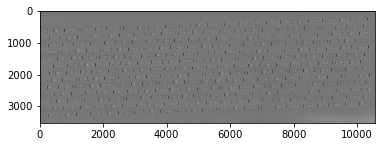

In [78]:
plt.imshow(image, cmap='gray')

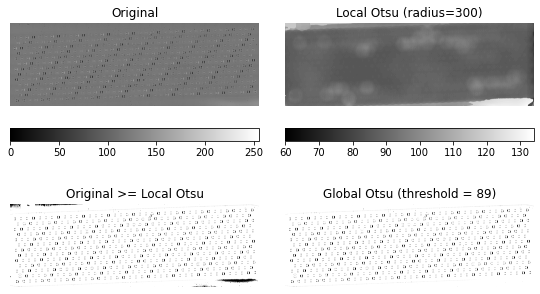

In [79]:
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk
from skimage.util import img_as_ubyte

img = img_as_ubyte(image)

radius = 300
selem = disk(radius)

local_otsu = rank.otsu(img, selem)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title('Local Otsu (radius=%d)' % radius)
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu' % threshold_global_otsu)
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax[3].axis('off')

plt.show()


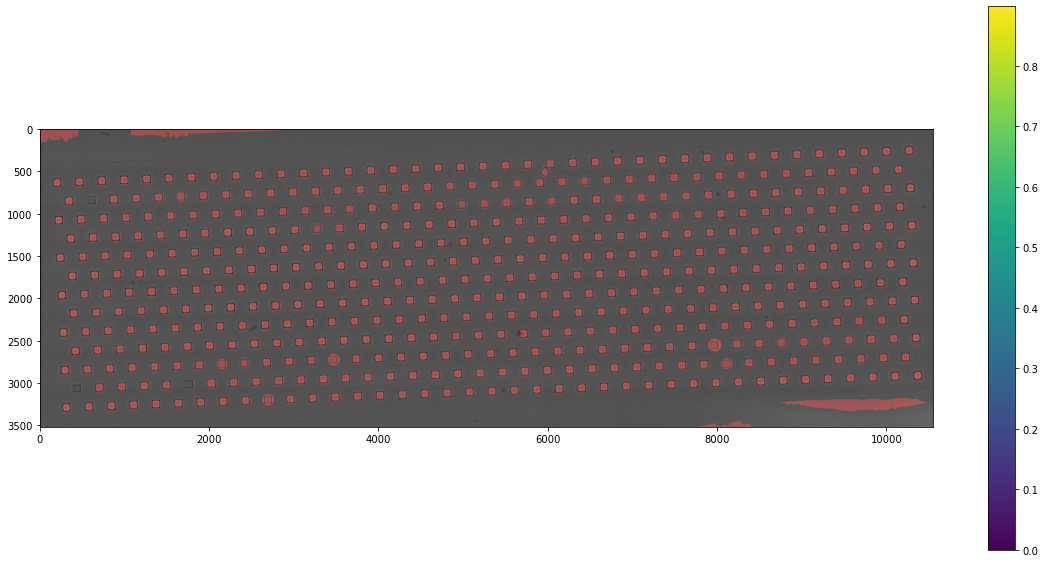

In [128]:
mask = img <= local_otsu
# mask = ndi.binary_erosion(mask, iterations=1)
mask = ndi.binary_fill_holes(mask)
mask = ndi.binary_erosion(mask, iterations=3)

mask = remove_small_objects(mask, min_size=5000)

labels = label(mask)

plt.subplots(figsize=(20,10))
plt.imshow(label2rgb(mask, image, bg_label=0),)
plt.colorbar()

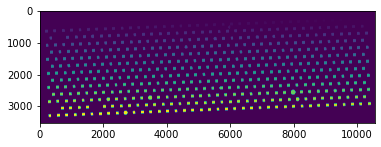

In [129]:
regions = regionprops(labels, intensity_image=None)


bad_regions = list(filter(lambda r: r.major_axis_length < 80 or r.major_axis_length > 180 or r.eccentricity > .7, regions))

good_mask = mask.copy()

if len(bad_regions) > 0:
    bad_mask = np.max([labels == br.label for br in bad_regions], axis=0)
    good_mask[bad_mask] = 0

plt.imshow(label(good_mask))
plt.show()

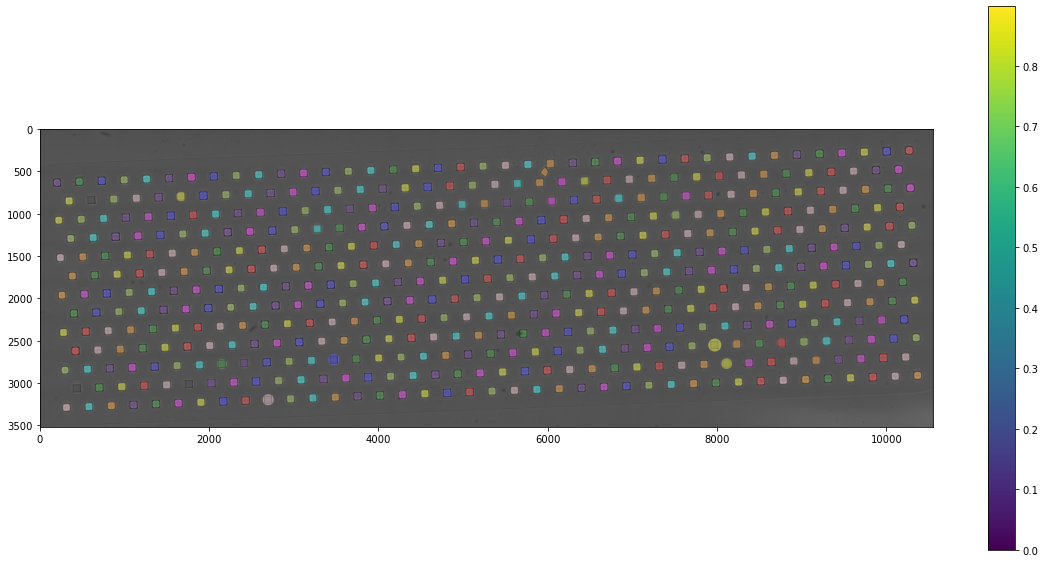

In [130]:

plt.subplots(figsize=(20,10))
plt.imshow(label2rgb(label(good_mask), image, bg_label=0),)
plt.colorbar()

In [131]:
import scipy 
A = label(good_mask)
good_labels = A

def get_outlines(labels):
     return labels * (np.abs(scipy.ndimage.laplace(labels)) > 0)

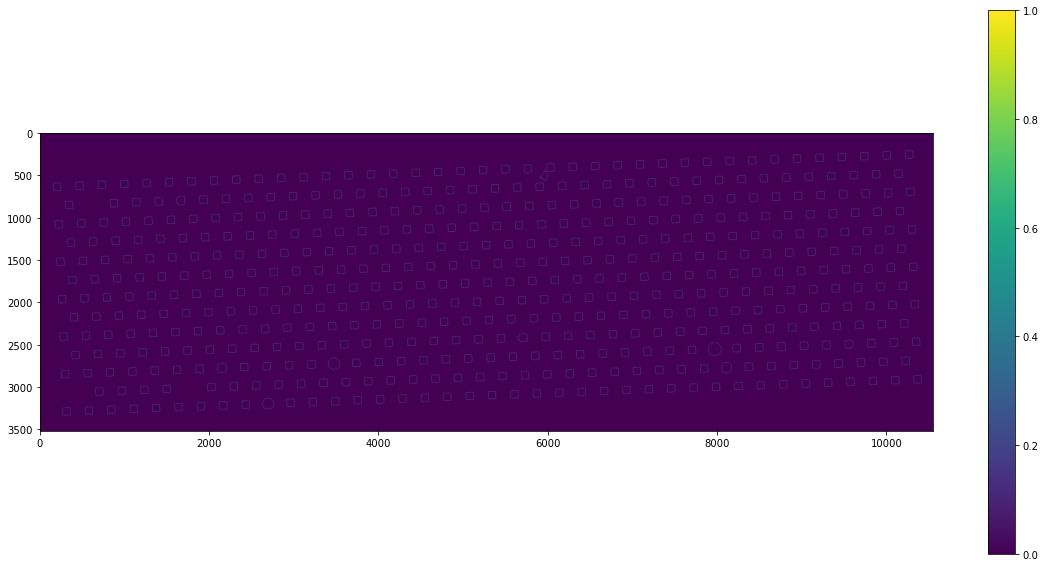

In [132]:

plt.subplots(figsize=(20,10))
plt.imshow(bg > 0)
plt.colorbar()

In [85]:
rfp_stack = imread('/home/aaristov/Multicell/SGR/20200811-CIPRO-7ngml-rep2_1.2_cellsperdrop/mean_projection_c2.tif')

In [133]:
rfp_stack.shape

(49, 3519, 10545)

In [134]:
def estimate_bg(values, eps=.1):
    '''iteratively shaves off the values higher than mean + 3 * std to get a good mean value''' 
    mean, std = values.mean(), values.std()
    good_values = values[values < mean + 3 * std]
    new_mean = good_values.mean()
    if np.abs(new_mean - mean) > eps:
        return estimate_bg(good_values)
    else:
        return new_mean        

def test_estimate_bg():
    from scipy.stats import norm
    dist = norm.rvs(9.0, 2.5, size=100)
    dist = np.concatenate((dist, [15, 20]))
    assert dist.mean()
    np.testing.assert_array_almost_equal(estimate_bg(dist), 9.0, .2)
    
test_estimate_bg()

In [135]:
def get_intensity_table(
    labelled_mask: np.ndarray,
    intensity_image_sequence: np.ndarray,
    estimator = np.mean,
    plot: bool = True
):
    assert (iis := intensity_image_sequence).ndim == 3, (
        f'expected 3D stack for intensity, got shape {iis.shape}'
    )
    df = pd.DataFrame(columns=['time', 'label', 'mean_intensity'])
    
    for t, img in enumerate(iis[:]):
        print('.', end='')
        def get_vals(label):
            mask = labelled_mask == label
            intensities = img[mask]
            return {'time': t, 'label': label, 'mean_intensity': estimator(intensities)}
        labels = np.unique(labelled_mask)
        labels = labels[labels > 0]
        vals = list(map(get_vals, labels))
        df1 = pd.DataFrame(data=vals)
        df = pd.concat([df, df1])

    if plot:
        plot_intensity_vs_time(df)
    return df



In [136]:
rfp_table = multiwell.get_intensity_table(label(good_mask), intensity_image_sequence=rfp_stack, plot=False)

In [44]:
rfp_table

time label  mean_intensity
0     0     0     1629.091675
1     0     1     1628.770630
2     0     2     1630.583496
3     0     3     1629.770020
4     0     4     1630.312866
..  ...   ...             ...
0    48     0     1624.875977
1    48     1     1701.264893
2    48     2     1684.204102
3    48     3     1626.151978
4    48     4     1630.003540

[245 rows x 3 columns]

In [137]:
bg_table = get_intensity_table(label(bg), intensity_image_sequence=rfp_stack, estimator=estimate_bg, plot=False)

.................................................

In [138]:
bg_table

time label  mean_intensity
0      0     1     1628.206665
1      0     2     1631.101807
2      0     3     1629.433350
3      0     4     1629.451050
4      0     5     1629.015015
..   ...   ...             ...
494   48   495     1624.809814
495   48   496     1629.846680
496   48   497     1626.822510
497   48   498     1627.741699
498   48   499     1626.185059

[24451 rows x 3 columns]

In [139]:
bg_free_table = pd.DataFrame()
bg_free_table['label'] = rfp_table.label
bg_free_table['time'] = rfp_table.time

# bg_free_table.index = rfp_table.time.values

bg_free_table['mean_intensity'] = rfp_table.mean_intensity

In [141]:
bg_free_table.loc[:,'bg'] = bg_table.mean_intensity.values
bg_free_table.loc[:, 'clean_intensity'] = bg_free_table.mean_intensity - bg_free_table.bg

In [142]:
bg_free_table

label time  mean_intensity           bg  clean_intensity
0       1    0     1628.631836  1628.206665         0.425171
1       2    0     1630.494751  1631.101807        -0.607056
2       3    0     1629.666992  1629.433350         0.233643
3       4    0     1630.187500  1629.451050         0.736450
4       5    0     1629.674805  1629.015015         0.659790
..    ...  ...             ...          ...              ...
494   495   48     1625.183716  1624.809814         0.373901
495   496   48     1698.332275  1629.846680        68.485596
496   497   48     1721.010498  1626.822510        94.187988
497   498   48     1694.966675  1627.741699        67.224976
498   499   48     1698.327515  1626.185059        72.142456

[24451 rows x 5 columns]

In [143]:
import seaborn as sns

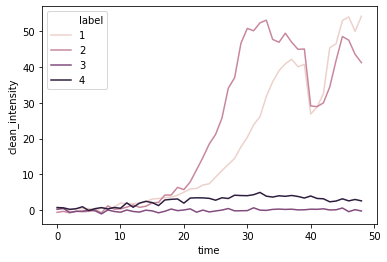

In [144]:
sns.lineplot(data=bg_free_table.query('label < 5'), x='time', y='clean_intensity', hue='label', estimator=None,)

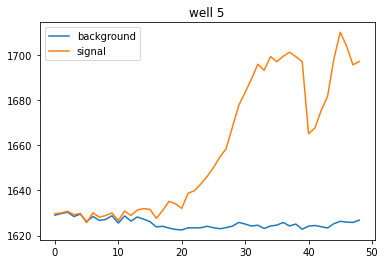

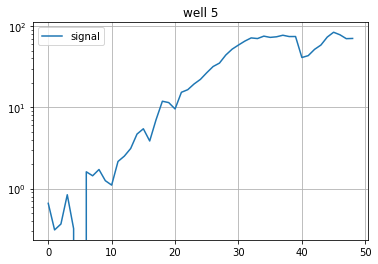

In [148]:
label = 5
plt.plot('time', 'bg', data=bg_free_table.query(f'label == {label}') , label='background')
plt.plot('time', 'mean_intensity', data=bg_free_table.query(f'label == {label}'), label='signal')
plt.legend()
plt.title(f'well {label}')
plt.show()

plt.semilogy('time', 'clean_intensity', data=bg_free_table.query(f'label == {label}'), label='signal')
plt.legend()
plt.title(f'well {label}')
plt.grid()
plt.show()

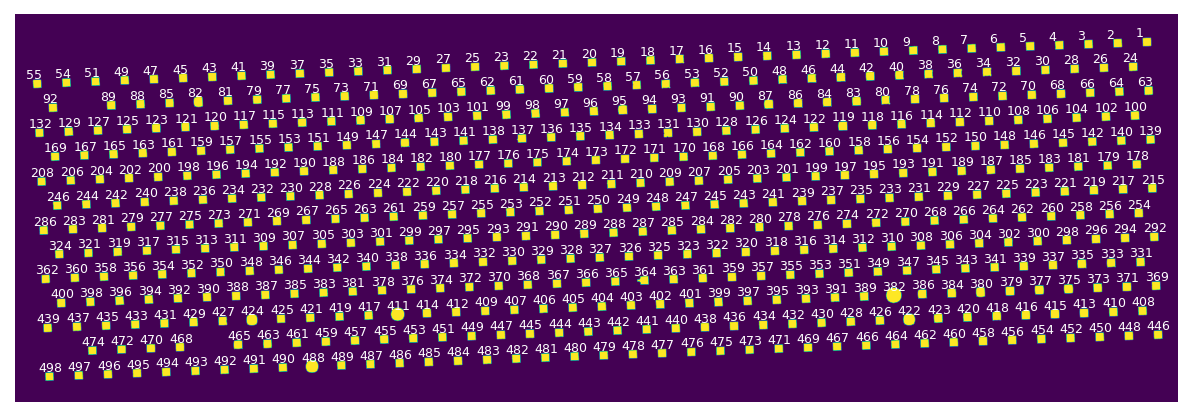

In [110]:
_  = multiwell.get_centers(good_labels, shift_labels=(-100,-50))

In [158]:
ff = abs(np.fft.fftshift(np.fft.fft2(good_mask)))

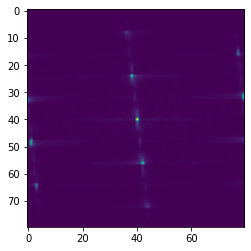

In [166]:
s = 40
c = np.array(ff.shape) // 2
plt.imshow(ff[c[0]-s:c[0]+s,c[1]-s:c[1]+s])

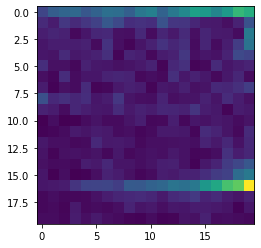

In [157]:
plt.imshow(ff[:20,-20:])

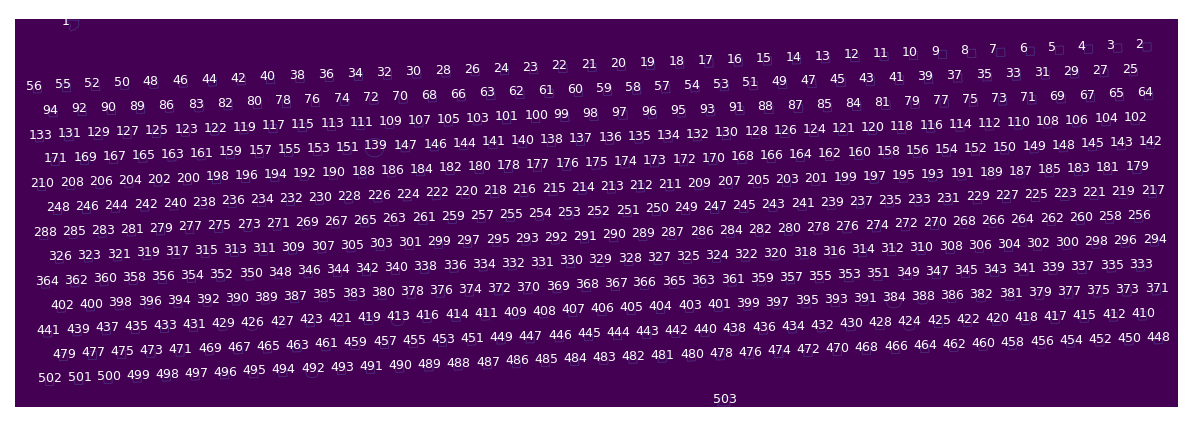

In [330]:
_  = multiwell.get_centers(bg, shift_labels=(-100,0))

data 294
data 292
data 290


(1628.9977, 10.803291, 1628.1578, 1628.0815)

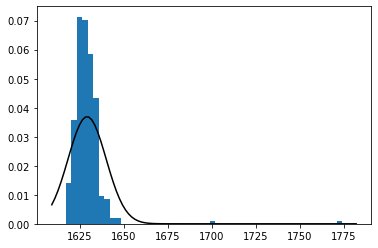

In [320]:
from scipy.stats import beta

BG_LABEL_3 = rfp_stack[8][bg == 3]

plt.hist(BG_LABEL_3, bins=50, density=True)
xmin, xmax = plt.xlim()
mu, sig = norm.fit(BG_LABEL_3)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mu, sig), 'k')
mu, sig, np.median(BG_LABEL_3), estimate_bg(BG_LABEL_3)

(1631.7555, 5.700123)

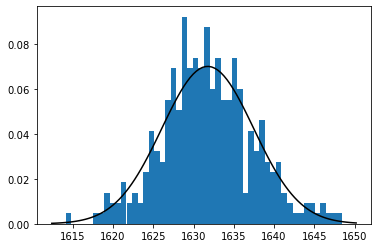

In [272]:
from scipy.stats import beta

BG_LABEL_3 = BG_LABEL_3[BG_LABEL_3 < mu + 3 * sig]
plt.hist(BG_LABEL_3, bins=50, density=True)
xmin, xmax = plt.xlim()
mu, sig = norm.fit(BG_LABEL_3)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mu, sig), 'k')
mu, sig

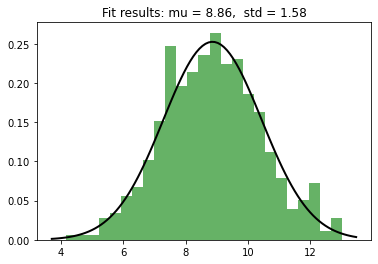

In [264]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = norm.rvs(9.0, 1.5, size=500)

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [229]:
from scipy.stats import norm

norm.fit(BG_LABEL_3)

(1635.2169, 13.274995)